# Laplacian experiment

This code attempts to learn a Laplacian prior J(x) = |x| without sampling from a Laplacian prior directly.

Instead, we suppose we have access to values of S(y) = min_{x \in \R} 0.5*||x-y||^{2}_{2} + J(x)

In [364]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set seed
np.random.seed(1)
torch.manual_seed(1)

# Parameters and auxiliary functions

In [365]:
# Dimension of the LPN
dim = 1

# Parameters of the prior J(x) = |x|

# proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1

# function to plot learned prox, convex function, original function
def plot_all(model):
    xi = np.linspace(-4, 4, 1000)
    
    y = prox(xi, model)
    c = cvx(xi, model)
    p = prior(xi, model)

    plt.rcParams["figure.figsize"] = (8, 3)

    # learned prox
    plt.subplot(1, 3, 1)
    plt.plot(xi, y, "-", ms=5, label="LPN")
    plt.plot(xi, soft_thr(xi), "--", label="soft thr.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # convex function
    plt.subplot(1, 3, 2)
    plt.plot(xi, c - c.min(), "-", ms=5, label="Cvx func")
    plt.plot(xi, gt_cvx(xi), "--", label="ref.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # original function
    plt.subplot(1, 3, 3)
    plt.plot(xi, p - p.min(), label="LPN")
    plt.plot(xi, np.abs(xi), "--", label=r"$\ell_1$", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Original func")

    plt.tight_layout()


## Model parameters

In [366]:
beta = 10  # beta of softplus
hidden = 50  # number of hidden units
layers = 4  # number of layers

# Generate sample points uniformly in the interval [a,b]
bsize = 200
a = -5.0
b = 5.0

input = torch.distributions.uniform.Uniform(a, b, validate_args=None).sample((bsize,))
input = input.unsqueeze(1).to(device)

# Evaluate the solution of the HJ PDE at these points
# Convert to pytorch
cvx_samples = gt_cvx(input)

## Training function

In [367]:
def single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss=None):
    # Compute the convex function from the input
    cvx_out = lpn_model.scalar(input)

    

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / bsize  # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / bsize  # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")



    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss

iteration 0 loss 14.919083595275879
iteration 0 loss 92.43938446044922
iteration 500 loss 2.188166618347168
iteration 1000 loss 1.6574920415878296
iteration 1500 loss 1.483486294746399
iteration 2000 loss 1.2674769163131714
iteration 2500 loss 1.0081572532653809
iteration 3000 loss 0.7050200700759888
iteration 3500 loss 0.3804255723953247
iteration 4000 loss 0.13912686705589294
iteration 4500 loss 0.03693344444036484
iteration 5000 loss 0.012529363855719566
iteration 5500 loss 0.005595115944743156
iteration 6000 loss 0.002995032351464033
iteration 6500 loss 0.0018719675717875361
iteration 7000 loss 0.001307177939452231
iteration 7500 loss 0.0009747685398906469
iteration 8000 loss 0.0007545754197053611
iteration 8500 loss 0.0005976737593300641
iteration 9000 loss 0.0004834447172470391
iteration 9500 loss 0.00039919480332173407
mse 5.344059944152832
mse 4.7774200439453125
mse 1.363465428352356
mse 0.37309229373931885
mse 0.09816707670688629
mse 0.01738913170993328
mse 0.00953575689345598

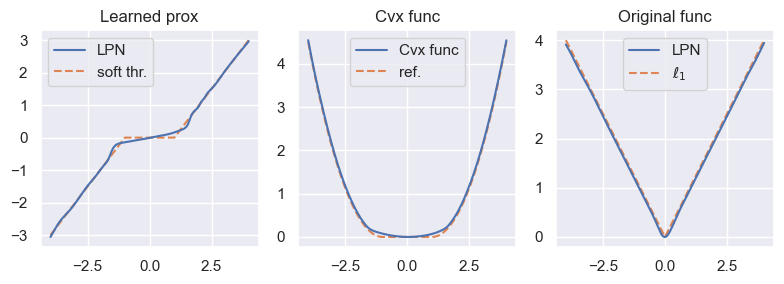

In [368]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(10000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

L1 loss

iteration 0 loss 2.8510937690734863
iteration 0 loss 9.093574523925781
iteration 500 loss 1.0016350746154785
iteration 1000 loss 0.7042697072029114
iteration 1500 loss 0.5599226355552673
iteration 2000 loss 0.27573761343955994
iteration 2500 loss 0.10132551938295364
iteration 3000 loss 0.06939859688282013
iteration 3500 loss 0.050936851650476456
iteration 4000 loss 0.04048571735620499
iteration 4500 loss 0.03343745321035385
iteration 5000 loss 0.03158339485526085
iteration 5500 loss 0.027363630011677742
iteration 6000 loss 0.02425592951476574
iteration 6500 loss 0.02085045538842678
iteration 7000 loss 0.02026284486055374
iteration 7500 loss 0.017905453220009804
iteration 8000 loss 0.01620117574930191
iteration 8500 loss 0.014341481029987335
iteration 9000 loss 0.015634069219231606
iteration 9500 loss 0.012081015855073929
mse 5.344010829925537
mse 4.850758075714111
mse 1.2285394668579102
mse 0.31581103801727295
mse 0.07948713004589081
mse 0.01575331948697567
mse 0.0033017327077686787
ms

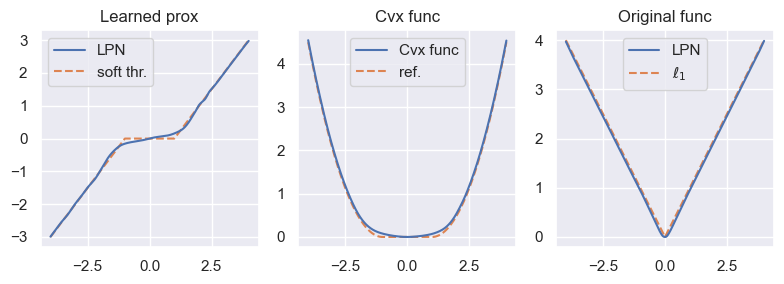

In [369]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 1

for i in range(1):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(10000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

## Proximal matching loss

We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma=10

iteration 0 loss 0.0751483142375946
iteration 500 loss 0.0009483942412771285
iteration 1000 loss 0.00016898632748052478
iteration 1500 loss 4.636794255929999e-05
iteration 0 loss 1.1924505088245496e-05
iteration 500 loss 1.0194182323175482e-05
iteration 1000 loss 8.351206815859769e-06
iteration 1500 loss 6.505847068183357e-06
mse 5.344090938568115
mse 4.946120738983154
mse 1.1549092531204224
mse 0.41099831461906433
mse 0.10933969169855118
mse 0.025940220803022385
mse 0.012315541505813599
mse 0.009442118927836418
mse 0.008315835148096085
mse 0.007696358021348715
final mse 0.007302037440240383
(1000,) (1000,) (1000,) (1000,)


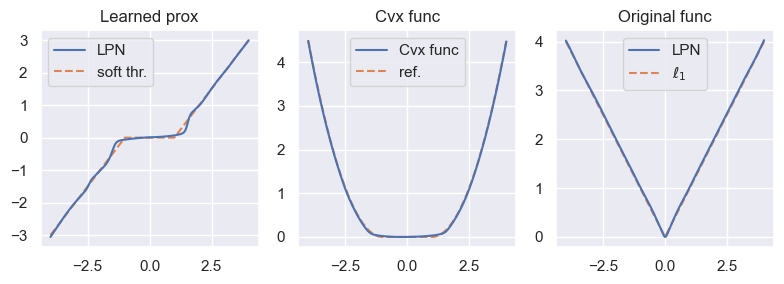

In [370]:
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 0
gamma_loss = 10

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-3

for i in range(1500):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(1500):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=5

iteration 0 loss 1.9146502381772734e-05
iteration 500 loss 5.201995463721687e-06
iteration 1000 loss 2.054572178167291e-06
iteration 1500 loss 1.3655424027092522e-06
iteration 2000 loss 1.131296130552073e-06
iteration 2500 loss 9.810923984332476e-07
iteration 3000 loss 8.344650268554688e-07
iteration 3500 loss 7.5668094723369e-07
mse 5.344018936157227
mse 4.309503078460693
mse 1.098438024520874
mse 0.3490506708621979
mse 0.10395237803459167
mse 0.025472121313214302
mse 0.0052667236886918545
mse 0.0018560863099992275
mse 0.0010748677887022495
mse 0.0007804751512594521
final mse 0.0006283241673372686
(1000,) (1000,) (1000,) (1000,)


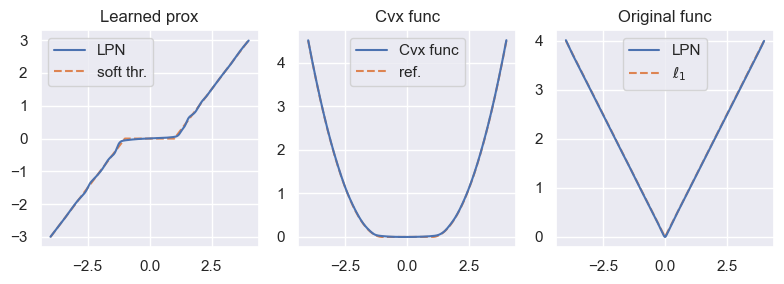

In [371]:
gamma_loss = 5

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(3000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=1

iteration 0 loss 1.745373083394952e-05


iteration 500 loss 1.5461444490938447e-05
iteration 1000 loss 1.3041198144492228e-05
iteration 1500 loss 1.1047422958654352e-05
iteration 2000 loss 9.369254257762805e-06
iteration 2500 loss 1.3729333659284748e-05
iteration 3000 loss 6.827413926657755e-06
iteration 3500 loss 5.81920130571234e-06
mse 5.344013214111328
mse 4.007979869842529
mse 1.109063982963562
mse 0.357772558927536
mse 0.1051391214132309
mse 0.027359511703252792
mse 0.005885245744138956
mse 0.0017013592878356576
mse 0.0008215459529310465
mse 0.0005517360987141728
final mse 0.00043195890611968935
(1000,) (1000,) (1000,) (1000,)


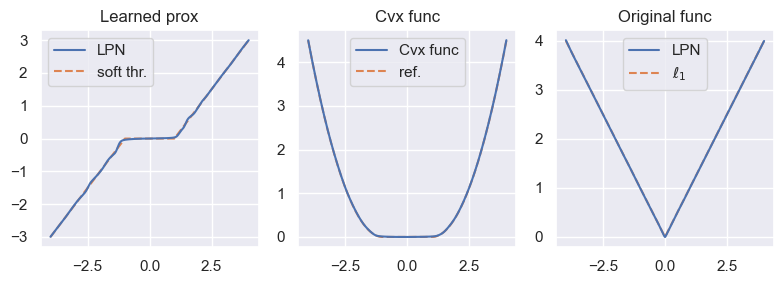

In [372]:
gamma_loss = 1

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(4000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)